In [26]:
import dask.dataframe as dd
import os
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, classification_report, auc, roc_curve, precision_recall_fscore_support, f1_score)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from itertools import permutations
import pandas as pd

# Paths

In [28]:
processed_dir = os.path.join( "..", "data", "processed")

final_dataset_path = os.path.join(processed_dir, 'FEData_For_Modelling.parquet')

minority_users_dt_pq = os.path.join(processed_dir, 'minority_users_dt.parquet')
minority_users_smote_dt_pq = os.path.join(processed_dir, 'minority_users_dt_smote.parquet')

minority_users_svm_pq = os.path.join(processed_dir, 'minority_users_svm.parquet')
minority_users_smote_svm_pq = os.path.join(processed_dir, 'minority_users_svm_smote.parquet')

minority_users_nn_pq = os.path.join(processed_dir, 'minority_users_nn.parquet')
minority_users_smote_nn_pq = os.path.join(processed_dir, 'minority_users_nn_smote.parquet')

minority_users_em_pq = os.path.join(processed_dir, 'minority_users_em_pq.parquet')


Import Dataset

In [3]:
# Read the multi-part Parquet dataset
dt_data = dd.read_parquet(minority_users_dt_pq)
smote_dt_data = dd.read_parquet(minority_users_smote_dt_pq)

svm_data = dd.read_parquet(minority_users_svm_pq)
smote_svm_data = dd.read_parquet(minority_users_smote_svm_pq)

nn_data = dd.read_parquet(minority_users_nn_pq)
smote_nn_data = dd.read_parquet(minority_users_smote_nn_pq)

svm_data.head(4000)

,User,Actual,Prediction,Confidence of Prediction
23,ACD1174,False,False,0.346870
29,ACH1840,False,False,0.646525
30,ACJ1797,False,False,0.509427
32,ACR1045,False,False,0.319632
44,AEF1032,False,False,0.474186
...,...,...,...,...
1966,YVJ0986,False,False,0.319705
1978,ZDH1266,False,False,0.537505
1981,ZHB1104,False,False,0.509979
1987,ZJT1601,False,False,0.645781


Checking if all Test users are there and are the same

In [4]:
a = set(svm_data['User'].values.compute())
b = set(nn_data['User'].values.compute())
c = set(dt_data['user'].values.compute())
d = set(smote_svm_data['User'].values.compute())
e = set(smote_nn_data['User'].values.compute())
f = set(smote_dt_data['user'].values.compute())
if a == b == c == d == e == f:
    print("All variables are equal.")

All variables are equal.


c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(
c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warning

Sorting Alphabetically

In [5]:
# Sort dt_data by 'User' column
sorted_dt_data = dt_data.sort_values(by='user')

# Sort smote_dt_data by 'User' column
sorted_smote_dt_data = smote_dt_data.sort_values(by='user')

# Sort svm_data by 'User' column
sorted_svm_data = svm_data.sort_values(by='User')

# Sort smote_svm_data by 'User' column
sorted_smote_svm_data = smote_svm_data.sort_values(by='User')

# Sort nn_data by 'User' column
sorted_nn_data = nn_data.sort_values(by='User')

# Sort smote_nn_data by 'User' column
sorted_smote_nn_data = smote_nn_data.sort_values(by='User')

sorted_dt_data.head()

,user,Actual,Prediction,Decision Path,GINI Confidence of Prediction,normal_prob,malicious_prob
209,ACD1174,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384
29,ACH1840,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384
309,ACJ1797,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384
262,ACR1045,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384
320,AEF1032,False,False,"[0, 1, 2, 3]",0.171213,0.99616,0.00384


Fixing DT exported dataframes before Ensembling

In [6]:
def fix_dt_df(df):
    df['Confidence of Prediction'] = df[['normal_prob', 'malicious_prob']].apply(lambda row: max(row), axis=1, meta=('float'))
    df = df.drop(['Decision Path','GINI Confidence of Prediction','normal_prob','malicious_prob'], axis=1)
    return df
sorted_dt_data = fix_dt_df(sorted_dt_data)
sorted_smote_dt_data = fix_dt_df(sorted_smote_dt_data)
sorted_smote_dt_data

,user,Actual,Prediction,Confidence of Prediction
npartitions=1,,,,
,string,bool,bool,float64
,...,...,...,...


# Selecting Best Ensemble

In [7]:
'''def ensemble_predictions(dt,svm,nn):
    conf_dt = np.maximum(dt['malicious_prob'].values.compute(),dt['normal_prob'].values.compute()) 
    conf_svm = svm['Confidence of Prediction'].values.compute()
    conf_nn = nn['Confidence of Prediction'].values.compute()
    total_conf = conf_dt + conf_svm + conf_nn
    weight_dt = conf_dt/total_conf
    weight_svm = conf_svm/total_conf
    weight_nn = conf_nn/total_conf
    y_pred = weight_dt*dt['Prediction'].values.compute() + weight_svm*svm['Prediction'].values.compute() + weight_nn*nn['Prediction'].values.compute()
    return  y_pred
    #dt[malicious_prob]*'''

"def ensemble_predictions(dt,svm,nn):\n    conf_dt = np.maximum(dt['malicious_prob'].values.compute(),dt['normal_prob'].values.compute()) \n    conf_svm = svm['Confidence of Prediction'].values.compute()\n    conf_nn = nn['Confidence of Prediction'].values.compute()\n    total_conf = conf_dt + conf_svm + conf_nn\n    weight_dt = conf_dt/total_conf\n    weight_svm = conf_svm/total_conf\n    weight_nn = conf_nn/total_conf\n    y_pred = weight_dt*dt['Prediction'].values.compute() + weight_svm*svm['Prediction'].values.compute() + weight_nn*nn['Prediction'].values.compute()\n    return  y_pred\n    #dt[malicious_prob]*"

Threshold Tuning

In [7]:
def calculate_tp_fp_fn(y_true, y_pred_prob, threshold):
    """
    Calculate True Positives (TP), False Positives (FP), and False Negatives (FN) 
    based on the given true labels (y_true) and predicted labels (y_pred) with a given threshold.
    
    Args:
    - y_true: True labels
    - y_pred: Predicted labels (probabilities or scores)
    - threshold: Threshold for classification
    
    Returns:
    - TP: Number of True Positives
    - FP: Number of False Positives
    - FN: Number of False Negatives
    """
    y_pred_binary = (y_pred_prob > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    TN, FP, FN, TP = cm.ravel()
    
    return TP, FP, FN

In [8]:
def threshold_tuning(y_test,y_pred_prob,tp_weight,fp_weight,fn_weight, threshold = 0.5):
    best_t_score = float('-inf')
    best_threshold = threshold
    while threshold >= 0: 
        Tp, Fp , Fn = calculate_tp_fp_fn(y_test, y_pred_prob, threshold)
        t_score = Tp*tp_weight - Fp*fp_weight - Fn*fn_weight
        if t_score > best_t_score:
            best_t_score = t_score
            best_threshold = threshold
        threshold -= 0.01
    return best_threshold

Ensemble Selection Tuning

In [9]:
def ensemble_predictions(*models):
    # Extract confidence values and predictions from each model
    confidences = []
    predictions = []
    for model in models:
        confidences.append(model['Confidence of Prediction'].values.compute())
        predictions.append(model['Prediction'].values.compute())

    # Calculate total confidence across all models
    total_conf = sum(confidences)
    conf_score = sum(confidences*(confidences/total_conf))
    # Calculate weights for each model
    weights = [conf / total_conf for conf in confidences]
    
    # Calculate weighted predictions
    y_pred = sum(weight * pred for weight, pred in zip(weights, predictions))
    
    return y_pred,conf_score

In [10]:
def find_best_ensemble_permutation(y_true,*models,threshold = 1,tp_weight=2,fp_weight=1,fn_weight=0.5):
    best_score = float('-inf')
    best_permutation = None
    best_y_pred_prob = None
    best_conf_score = None
    total_permutations = len(list(permutations(models)))
    print(total_permutations)
    for permutation in permutations(models):
        y_pred_prob,conf_score = ensemble_predictions(*permutation)
        tp, fp, fn = calculate_tp_fp_fn(y_true, y_pred_prob, threshold)
        score = tp * tp_weight
        if score > best_score:
            best_score = score
            best_permutation = permutation
            best_y_pred_prob = y_pred_prob
            best_conf_score = conf_score
        total_permutations-=1
        print(total_permutations)
    return best_permutation, best_score , best_y_pred_prob, best_conf_score

In [11]:
y_test = sorted_svm_data['Actual'].values.compute()
best_permutation, best_score , best_y_pred_prob, best_conf_score= find_best_ensemble_permutation(y_test,sorted_svm_data,sorted_nn_data,sorted_dt_data,sorted_smote_svm_data,sorted_smote_nn_data,sorted_smote_dt_data,threshold = 0)
print("Best permutation:", best_permutation)
print("Best score:", best_score)

720
719
718
717
716
715
714
713
712
711
710
709
708
707
706
705
704
703
702
701
700
699
698
697
696
695
694
693
692
691
690
689
688
687
686
685
684
683
682
681
680
679
678
677
676
675
674
673
672
671
670
669
668
667
666
665
664
663
662
661
660
659
658
657
656
655
654
653
652
651
650
649
648
647
646
645
644
643
642
641
640
639
638
637
636
635
634
633
632
631
630
629
628
627
626
625
624
623
622
621
620
619
618
617
616
615
614
613
612
611
610
609
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
586
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
543
542
541
540
539
538
537
536
535
534
533
532
531
530
529
528
527
526
525
524
523
522
521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
502
501
500
499
498
497
496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471


Threshold tuning

0.26999999999999935
Accuracy = 98.75%
Precision = 0.4
Recall = 0.5
f-1 score = 0.4444444444444445

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.99      0.99       396
        True       0.40      0.50      0.44         4

    accuracy                           0.99       400
   macro avg       0.70      0.75      0.72       400
weighted avg       0.99      0.99      0.99       400



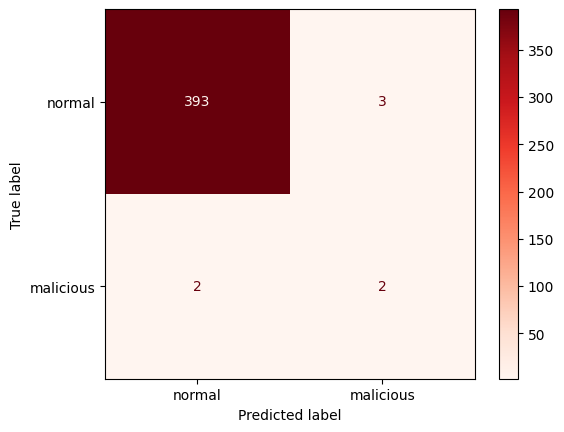

In [12]:
threshold = threshold_tuning(y_test,best_y_pred_prob,tp_weight= 2, fp_weight= 1,fn_weight=0.5,threshold = 1)
print(threshold)
y_pred = (best_y_pred_prob > threshold).astype(int)
set(list(y_pred.flatten()))


accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['normal', 'malicious'])

print("Accuracy = {:.2f}%".format(accuracy_score(y_test, y_pred)*100))
print("Precision = {}".format(precision_score(y_test, y_pred)))
print("Recall = {}".format(recall_score(y_test, y_pred)))
print("f-1 score = {}".format(f1_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
disp.plot(cmap=plt.cm.Reds)
plt.show()

AUC score: 0.7462121212121213


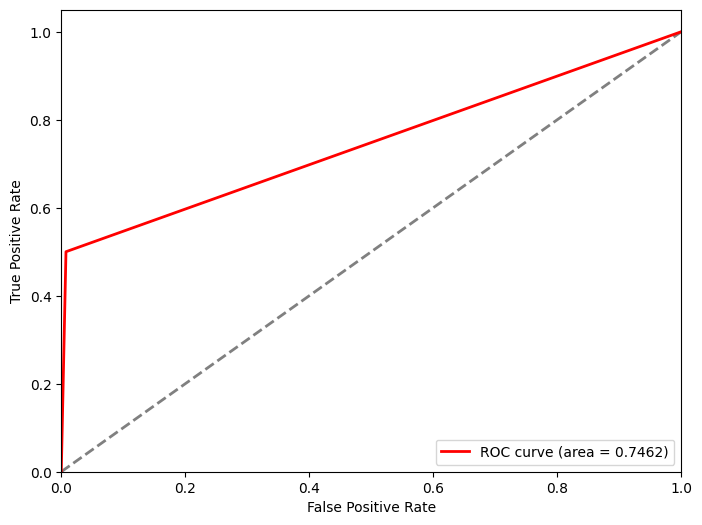

In [13]:
# ROC - AUC
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    plt.figure(figsize=(8, 6))
    #y_prob = best_dt.predict_proba(X_test_scaled)[::,1]
    dt_fpr, dt_tpr, thresholds = roc_curve(true_y, y_prob)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    roc_auc = auc(dt_fpr, dt_tpr)
    plt.plot(dt_fpr, dt_tpr, color='red', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.legend(loc="lower right")

    # plt.legend()

plot_roc_curve(y_test, y_pred)
print(f'AUC score: {roc_auc_score(y_test, y_pred)}')

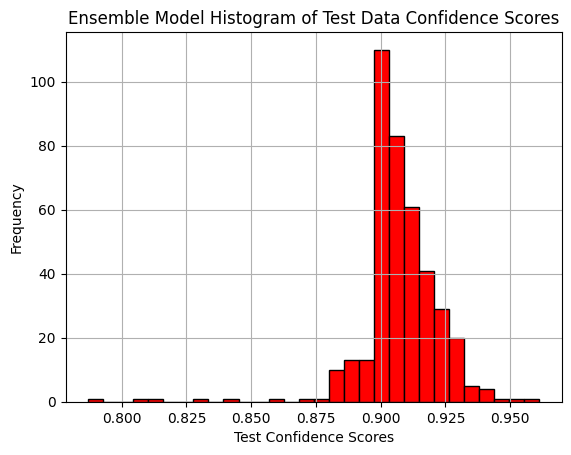

In [23]:
# Plot histogram for test risk score
plt.hist(best_conf_score, bins=30, edgecolor='black', color = "red")  # Adjust bins as needed
plt.xlabel('Test Confidence Scores')
plt.ylabel('Frequency')
plt.title('Ensemble Model Histogram of Test Data Confidence Scores')
plt.grid(True)
plt.show()

#  Our Prediction and the Confidence Associated with it

## Helper Functions

In [22]:
def df_toparquet(pdf,path):
    ddf = dd.from_pandas(pdf)
    # Export the DataFrame to a parquet file=
    ddf.to_parquet(path, engine='pyarrow')


In [15]:
def get_minority_tables(y_pred_value, y_test_value,df):
    # Get rows of minority data
    minority_data = df[(df['Actual'] == y_test_value) & (df['Prediction'] == y_pred_value)]
    display(minority_data)

Creating Table for export

In [31]:
names_array = list(smote_svm_data['User'].values.compute())
final_guess = {'User': names_array, 'Actual': list(y_test.astype(bool)), 'Prediction': list(y_pred.flatten().astype(bool)), 'Confidence of Prediction': list(best_conf_score.flatten())}
refactored_df = pd.DataFrame(final_guess)
df_toparquet(refactored_df,minority_users_em_pq)
refactored_df


c:\Users\hydro\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\core.py:3930: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(


,User,Actual,Prediction,Confidence of Prediction
0,ACD1174,False,False,0.907497
1,ACH1840,False,False,0.944440
2,ACJ1797,False,False,0.899019
3,ACR1045,False,False,0.922465
4,AEF1032,False,False,0.910980
...,...,...,...,...
395,YVJ0986,False,False,0.909995
396,ZDH1266,False,False,0.916107
397,ZHB1104,False,False,0.898962
398,ZJT1601,False,False,0.891902


In [30]:
print("False Positives")
get_minority_tables(1, 0,refactored_df)

print("False Negatives")
get_minority_tables(0, 1,refactored_df)

print("True Positives")
get_minority_tables(1,1,refactored_df)

False Positives


,User,Actual,Prediction,Confidence of Prediction
128,ERM1590,False,True,0.884431
208,KCR1118,False,True,0.787100
246,MEB1743,False,True,0.885108


False Negatives


,User,Actual,Prediction,Confidence of Prediction
359,TMT0851,True,False,0.961129
360,TNB1616,True,False,0.891598


True Positives


,User,Actual,Prediction,Confidence of Prediction
243,MCP0611,True,True,0.893690
281,OKM1092,True,True,0.840506
